<a href="https://colab.research.google.com/github/du-hr/CrowdCounter/blob/pyramids/Crowd_Counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE 415 Course Project - Counting People in a Shopping Mall


> Final Project of ECSE 415 (Fall 2020) @ McGill University


> Authors (G32): Haoran Du (260776911), Daniel Aird (260865951), Carlo D'Angelo (260803454), Jed Lamari-Saysset (260848706)





## **0. Initialization (First run?-> Run, restart runtime, and run again)**

In [2]:
#Initialization of Detectron2 + restart runtime
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
#exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
import cv2
import numpy as np
import scipy as sci
import pandas as pd
from google.colab import drive
#Import for the Local Binary Pattern
from skimage.feature import local_binary_pattern
from sklearn import svm
# ignore the follwoing line if running locally
drive.mount('/content/drive')
# make path = './' if running locally
path = '/content/drive/My Drive/frames/frames/'

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Datasets**

### **1.1 Import Data**

Instructions: If this is your first time running the code, uncomment Section 1.1 and Section 1.2 and import the dataset from the images. Then, download the new datasetGray.npz file so you can use that next time. If you already have the datasetGray.npz file saved, just upload it to the session and load it using Section 1.3.

In [5]:
# images = []

# # load seq_000001.jpg to seq_000009.jpg
# for i in range(9):
#   path_i = path + 'seq_00000' + str(i+1) +'.jpg'
#   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

# # load seq_000010.jpg to seq_000099.jpg
# for i in range(9,99):
#   path_i = path + 'seq_0000' + str(i+1) +'.jpg'
#   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

# # load seq_000100.jpg to seq_000999.jpg
# for i in range(99,999):
#   path_i = path + 'seq_000' + str(i+1) +'.jpg'
#   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

# # load seq_001000.jpg to seq_002000.jpg
# for i in range(999,2000):
#   path_i = path + 'seq_00' + str(i+1) +'.jpg'
#   images.append(cv2.cvtColor(cv2.imread(path_i), cv2.COLOR_BGR2GRAY))

### **1.2 Save Dataset**

In [6]:
#datasetGray = np.asarray(images)
#np.savez('datasetGray', datasetGray)

### **1.3 Load Saved Dataset**

In [7]:
# Read the datasetGray ndarray instead of importing every image
datasetGray = np.load('/content/drive/My Drive/datasetGray.npz')

## **2. Existing Person Detection Models**




/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


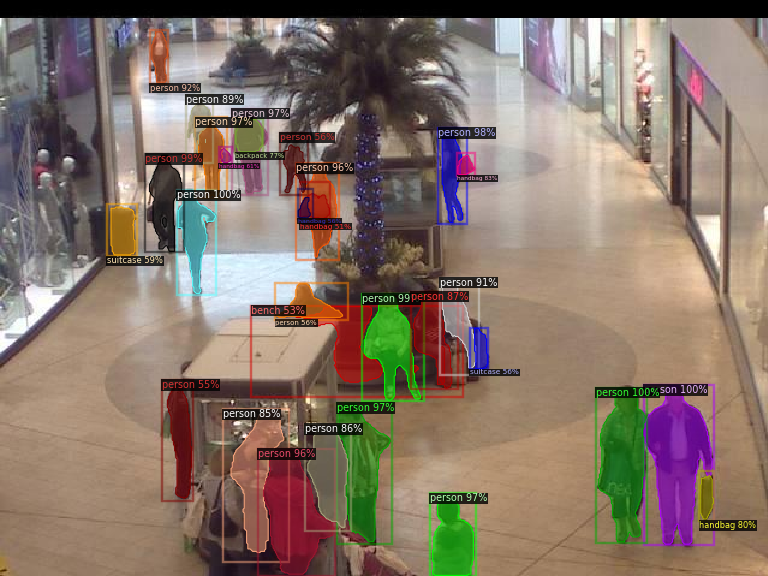

In [8]:
#Get test image from the dataset
im = cv2.imread(path + 'seq_001073.jpg')

#Configure the detector
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
#print(outputs["instances"].pred_classes)
#print(outputs["instances"].pred_boxes)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [9]:
# box is defined by its top left corner and bottom right corner
boxes_object = outputs["instances"].pred_boxes.clone()
# class 0 is a person
classes_list = outputs["instances"].pred_classes.tolist()

# extract top left corner point and bottom right corner point 
# of every box from Boxes object 
boxesOfPerson_list = []

for i,j in enumerate(boxes_object.__iter__()):
  # only consider boxes with person class
  if classes_list[i] == 0:
    boxesOfPerson_list.append(j.tolist())
boxesOfPerson = np.array(boxesOfPerson_list)

person_images_list = [] # list of 2D person images that were cropped out

#Find the max and mins of the cropped images to see what our windows should be
box = boxesOfPerson[0]
maxWidth = int(box[2] - box[0]  + 1)
maxHeight = int(box[3] - box[1] + 1)
minWidth = int(box[2] - box[0] + 1)
minHeight = int(box[3] - box[1] + 1)

# crop out the people from image
for k in range(boxesOfPerson.shape[0]):
  box = boxesOfPerson[k]
  height = int(box[3] - box[1] + 1)
  if height > maxHeight: maxHeight = height
  if height < minHeight: minHeight = height
  width = int(box[2] - box[0] + 1)
  if width > maxWidth: maxWidth = width
  if width < minWidth: minWidth = width
  crop_img = im[int(box[1]):int(box[1])+height, int(box[0]):int(box[0])+width]
  person_images_list.append(crop_img)
  #cv2_imshow(crop_img)
person_images = np.array(person_images_list)

#Now we have the list of people in the image, create random images without people

from PIL import Image
from matplotlib import cm

#Get the random images
notPeople = []
for i in range(100):
  #Create random width and height
  w = random.randrange(minWidth, maxWidth)
  h = random.randrange(minHeight, maxHeight)

  #Create random location
  x = random.randrange(0, len(im[0])-w)
  y = random.randrange(0, len(im)-h)
  location = (x, y)

  isPerson = False
  #Make sure the random location doesnt intersect with the boxes of people
  for p in boxesOfPerson:
    #If a corner of person is in random window, cancel (4 corners = 4 cases)
    if x < p[0] and y < p[1] and x+w > p[0] and y+h > p[1]: isPerson = True
    elif x+w > p[2] and y < p[1] and x < p[2] and y+h > p[1]: isPerson = True
    elif x < p[0] and y+h > p[3] and x+w > p[0] and y < p[3]: isPerson = True
    elif x < p[2] and y < p[3] and x+w < p[2] and y+h > p[3]: isPerson = True
    elif x < p[0] and y < p[1] and x+w > p[2] and y+h > p[3]: isPerson = True
    #If a corner of random window is in person, cancel (4 corners = 4 cases)
    elif p[2] > x+w and p[1] < y and p[0] < x+w and p[3] > y: isPerson = True
    elif p[0] < x and p[1] < y and p[2] > x and p[3] > y: isPerson = True
    elif p[2] > x and p[1] < y+h and p[0] < x and p[3] > y+h: isPerson = True
    elif p[0] < x+w and p[1] < y+h and p[2] > x+w and p[3] > y+h: isPerson = True
    #None of the corners interact, but the images still touch (2 cases, if one doesnt work then the other shouldnt either)
    elif x < p[0] and y > p[1] and x < p[2] and y < p[3] and x+w > p[0] and y+h > p[1] and x+w > p[2] and y+h < p[3]: isPerson = True
    elif p[0] < x and p[1] > y and p[0] < x+w and p[1] < y+h and p[2] > x and p[3] > y and p[2] > x+w and p[3] < y+h: isPerson = True


  if not isPerson:
    notPerson = Image.fromarray(np.uint8(im)).convert('RGB')
    notPerson = notPerson.crop((x, y, x+w, y+h))
    #Change to numpy array for consistency
    notPerson = np.array(notPerson)
    notPeople.append(notPerson)

notPeople = np.array(notPeople)

#Lets display the notPeople images
#for notPerson in notPeople:
  #cv2_imshow(notPerson)

So at this point we have the list of people cropped out:
person_images_list (list of ndarrays)
And we have the list of non-people cropped out:
notPeople (list of ndarrays)

Since i make 100 random locations in the image and then discard the ones that intersect with people, we are left with around 30 images of non-people in the list, this can be increased by just increasing the number of iterations

The size of the random images works like this: i looked at the actual people sizes and took the max and min width and height of those windows. I sent made the random windows have width (minWidth, maxWidth) and height (minHeight, maxHeight). This could be a parameter we change to get better results

The next thing is: do this with a lot more images than just one, get the features from people and non-people and then i guess send them through SVM

## **3. SVM Model**

Original Dimensions :  (480, 640, 3)


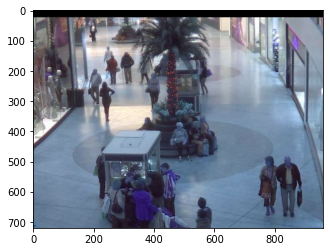

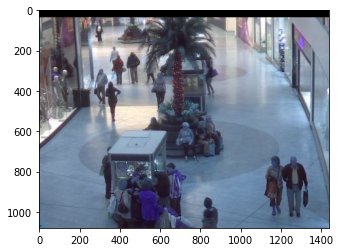

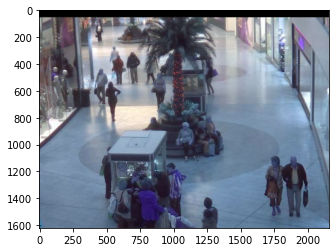

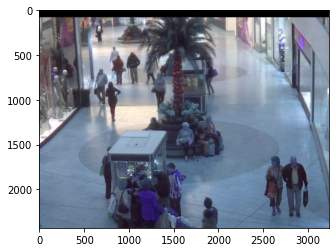

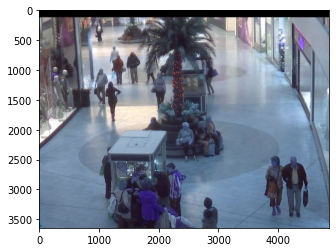

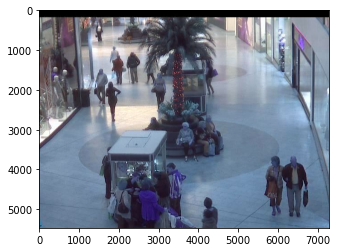

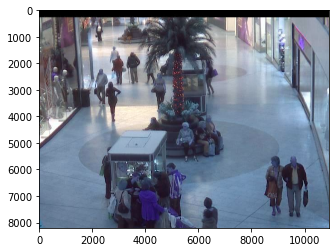

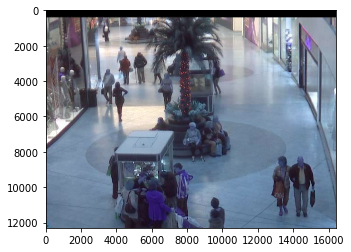

In [10]:
# image pyramid:  multi-scale representation

im_test = cv2.imread(path + 'seq_001073.jpg')
 
print('Original Dimensions : ',im_test.shape)


for i in range(8):
  scale_percent = 150 # percent of original size
  width = int(im_test.shape[1] * scale_percent / 100)
  height = int(im_test.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  im_test = cv2.resize(im_test, dim, interpolation = cv2.INTER_AREA)
  plt.imshow(im_test)
  plt.show()

In [11]:
# TRAIN IMAGES (from only one surveillance image)
train_images = np.concatenate((person_images, notPeople))
#print(train_images.shape[0])
# TRAIN LABELS (from only one surveillance image)
labels_person = np.array([1] * person_images.shape[0]) # person patches have a label of 1
labels_not_person = np.array([0] * notPeople.shape[0]) # not person patches have a label of 0
train_labels = np.concatenate((labels_person, labels_not_person))
#print(train_labels.shape[0])

def resize(image_list, new_size):
  resizedList = []
  for i in image_list :
    resized_img = cv2.resize(i, new_size)
    resizedList.append(resized_img)
  return resizedList

def HoGFeatures(image_list,img_size, cell_size, block_size, nbins):
  #Creating the HOGDescriptor
  hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
  features = []
  image_list = np.asarray(image_list)
  for i in image_list :
    features.append(hog.compute((i*255).astype(np.uint8)).reshape(1, -1)) #Appending the hogFeatures
  features = np.vstack(features)
  return features

#Start of SVM Classifier
resized_train_images = resize(train_images, (64, 64))
trainFeatures = HoGFeatures(resized_train_images, (64,64), (8,8), (4,4), 4)

#Fitting a non-linear SVM classifier
clf = svm.SVC(gamma=0.3, C=700, random_state= None)
clf.fit(trainFeatures ,train_labels)

#First we need to implement the Local Binary Pattern, for each of the images of people
#histogram_data = []
#numberOfPoints= 24 #3*8
#radius= 3
#for image in person_images: #This is only for a list of people
#  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#  LocalBinaryPatternTemp = local_binary_pattern(image, numberOfPoints, radius) #Error because image has 3 dimensions, but should have 2 
#  flattenedArray = LocalBinaryPatternTemp.flatten()
#  (histograms, bin_edges) = np.histogram(flattenedArray) #There are other parameters, don't understand what they are used for 
#  histogram_data.append(histograms)

#classifier = svm.SVC(gamma=0.3, C=700, random_state = None)
#classifier.fit(histogram_data, "People" )

#Some Tutorials online put the type of the historgram as float and normalize it(To keep in mind)

SVC(C=700, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## **3. Performance**

In [12]:
# function that computes the Intersection-over-union (IoU)
def find_IoU(boxA, boxB):
  # NUMERATOR
  # determine the top left corner of the intersection rectangle
  x_tlc = max(boxA[0], boxB[0])
  y_tlc = max(boxA[1], boxB[1])
  # determine the bottom right corner of the intersection rectangle
  x_brc = min(boxA[2], boxB[2])
  y_brc = min(boxA[3], boxB[3])
  # calculate the area of overlap between the predicted bounding box and the ground-truth bounding box
  overlap_area = max(0, x_brc - x_tlc + 1) * max(0, y_brc - y_tlc + 1)
  
  # DENOMINATOR
  # calculate the area of the predicted bounding box and the area of the ground-truth bounding box separately
  boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # calculate the  area of union
  # i.e., the area encompassed by both the predicted bounding box and the ground-truth bounding box
  union_area = boxA_area + boxB_area - overlap_area
  
  # IoU
  # compute the intersection over union
  iou = overlap_area / float(union_area)
  return iou